# **Análise de Dados - Hipertensão**

## Importando as bibliotecas necessárias

In [1]:
!pip install pycaret

     |████████████████████████████████| 319 kB 4.1 MB/s 
     |████████████████████████████████| 1.3 MB 27.7 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
     |████████████████████████████████| 56 kB 5.9 MB/s 
     |████████████████████████████████| 116 kB 92.7 MB/s 
     |████████████████████████████████| 2.0 MB 45.8 MB/s 
     |████████████████████████████████| 261 kB 77.0 MB/s 
     |████████████████████████████████| 1.7 MB 60.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.5 MB 46.2 MB/s 
     |████████████████████████████████| 6.8 MB 47.5 MB/s 
     |████████████████████████████████| 167 kB 66.0 MB/s 
     |████████████████████████████████| 636 kB 70.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 102 kB 13.6 MB/s 
     |███████████████████

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files



## Importando os dados

In [ ]:
uploaded = files.upload()

Saving demographic.csv to demographic.csv
Saving diet.csv to diet.csv
Saving examination.csv to examination.csv
Saving labs.csv to labs.csv
Saving medications.csv to medications.csv
Saving questionnaire.csv to questionnaire.csv


## Juntando os datasets

In [2]:
## dataset 'medications' == 'questionnaire'
demo = pd.read_csv('demographic.csv')
diet = pd.read_csv('diet.csv')
exam = pd.read_csv('examination.csv')
labs = pd.read_csv('labs.csv')
quest = pd.read_csv('questionnaire.csv')


In [3]:
demo.drop(['SEQN'], axis=1, inplace=True)
diet.drop(['SEQN'], axis=1, inplace=True)
exam.drop(['SEQN'], axis=1, inplace=True)
labs.drop(['SEQN'], axis=1, inplace=True)
quest.drop(['SEQN'], axis=1, inplace=True)

In [4]:
df = pd.concat([demo, diet, exam, labs, quest], axis=1, join='inner')


In [5]:
df.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,8,2,1,69,NaN,4,4,1.0,NaN,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,8,2,1,54,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,8,2,1,72,NaN,3,3,2.0,NaN,1.0,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,8,2,1,9,NaN,3,3,1.0,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,8,2,2,73,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In [6]:
df.shape

(9813, 1811)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 1811 entries, SDDSRVYR to WHQ520
dtypes: float64(1753), int64(27), object(31)
memory usage: 135.6+ MB


## Eliminando colunas 'duplicadas' que servem apenas para conversão de unidades

In [8]:
cols = [c for c in df.columns if c[-2:]!= 'SI']

## Definindo as colunas que serão usadas

In [9]:
## hipertensão (blood pressure)
#df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'BPXSY1', 'BPXDI1', 'HSD010', 'LBXMC', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'PEASCST1', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]


## hipertensão (blood pressure - versao streaming)
df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'BPXSY1', 'LBXMC', 'MCQ160B', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]



# Dicionário de Features

In [10]:
''' col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'BPXSY1' : 'Systolic_bp',               # Systolic: Blood pres (1st rdg) mm Hg 
'BPXDI1' : 'Diastolic_bp',              # Diastolic: Blood pres (1st rdg) mm Hg
'HSD010' : 'GenHlth',            # General Health Condition ------ 1 = Excelent  2 = Very good  3 = Good  4 = Fair  5 = Poor   
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160B' : 'Congestive_heart_failure', # Ever told had congestive heart failure ------  0 = no  1 = yes
'MCQ160C' : 'Coronary_heart_disease',   # Ever told you had coronary heart disease ------  0 = no  1 = yes
'MCQ160D' : 'Angina',                   # Ever told you had angina/angina pectoris ------  0 = no  1 = yes
'MCQ160E' : 'Heart_attack',             # Ever told you had heart attack ------  0 = no  1 = yes 
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'PEASCST1' : 'BP_status',               # Blood Pressure Status ------ 0 = parcial  1 = complete  3 = not done     
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}
 '''


col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'BPXSY1' : 'Systolic_bp',               # Systolic: Blood pres (1st rdg) mm Hg 
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160B' : 'Congestive_heart_failure', # Ever told had congestive heart failure ------  0 = no  1 = yes
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}

In [11]:
df = df.rename(columns = col_decoder)

## Convertendo dados para as medidas corretas

In [12]:
df['Height_cm'] = df['Height_cm'] * 2.54

In [13]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,122.0,33.4,2.0,1.0,2.0,2.0,1,69,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,156.0,32.5,2.0,2.0,2.0,2.0,1,54,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,140.0,34.3,2.0,2.0,1.0,2.0,1,72,177.80,3.0
3,NaN,17.1,32.2,NaN,NaN,108.0,34.0,NaN,NaN,NaN,NaN,1,9,NaN,NaN
4,1.0,19.7,52.0,1.0,2.0,136.0,33.0,2.0,2.0,1.0,2.0,2,73,170.18,NaN


## Lidando com Nulls

In [14]:
## Quando o paciente se recusa a responder uma questão ou quando 'não se aplica', são usadas combinações de números 7 e 9
df.replace({7:None, 9:None, 77:None, 99:None, 777:None, 999:None, 7777:None, 9999:None, 77777:None, 99999:None, 777777:None, 999999:None, 55:None, 555:None, 5555:None, 8:None, 88:None}, inplace=True)


In [15]:
df = df.dropna()

In [16]:
df.nunique()

Drink_alcohol                 2
BMI                         316
Weight_kg                   695
HighBP                        2
HighChol                      2
Systolic_bp                  56
Hemoglobin_concentration     60
Congestive_heart_failure      2
Stroke                        2
Relative_heart_attack         2
Exercising                    2
Sex                           2
Age                          59
Height_cm                    26
Smoker                        3
dtype: int64

In [17]:
# df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']].replace(2.0,0)

df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure',	'Stroke',	'Relative_heart_attack',	'Exercising']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure',	'Stroke',	'Relative_heart_attack',	'Exercising']].replace(2.0,0)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [18]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,122.0,33.4,0.0,1.0,0.0,0.0,1,69.0,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,156.0,32.5,0.0,0.0,0.0,0.0,1,54.0,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,140.0,34.3,0.0,0.0,1.0,0.0,1,72.0,177.80,3.0
5,1.0,41.7,105.0,1.0,1.0,160.0,34.2,0.0,0.0,0.0,1.0,1,56.0,162.56,3.0
9,1.0,22.0,65.3,0.0,0.0,140.0,35.3,0.0,0.0,0.0,1.0,2,56.0,154.94,1.0


## Removendo linhas e colunas com grande quantidade de nulls

In [19]:
def filter_columns(df, cutoff=0.9):
    tot_rows = df.shape[0]
    removed_cols = []
   
    for col in df.columns:
        num_na = df[col].isna().sum()
        if (num_na/tot_rows) > cutoff:
            removed_cols.append(col)
    return df.drop(removed_cols, axis=1)
    
def filter_rows(df, cutoff=0.9):
    tot_cols = df.shape[1]
    df = df[df.isnull().sum(axis=1) < tot_cols*cutoff]
    return df

In [20]:
df.isnull().sum()

Drink_alcohol               0
BMI                         0
Weight_kg                   0
HighBP                      0
HighChol                    0
Systolic_bp                 0
Hemoglobin_concentration    0
Congestive_heart_failure    0
Stroke                      0
Relative_heart_attack       0
Exercising                  0
Sex                         0
Age                         0
Height_cm                   0
Smoker                      0
dtype: int64

In [21]:
df = df[df['Age'] > 18]

In [22]:
df.shape

(1336, 15)

In [23]:
df.sample(10)

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
1664,1.0,20.7,65.1,1.0,1.0,112.0,34.2,0.0,0.0,0.0,1.0,1,44.0,170.18,1.0
3896,1.0,24.7,79.1,0.0,0.0,116.0,32.3,0.0,0.0,0.0,1.0,2,57.0,165.10,1.0
2720,1.0,30.5,70.4,0.0,0.0,102.0,32.8,0.0,0.0,0.0,1.0,1,80.0,180.34,3.0
3453,1.0,28.5,68.3,1.0,1.0,126.0,33.9,0.0,0.0,0.0,0.0,1,44.0,162.56,2.0
7423,1.0,24.2,68.9,1.0,0.0,122.0,33.6,0.0,0.0,1.0,1.0,2,44.0,162.56,1.0
5716,1.0,27.0,63.7,1.0,1.0,180.0,32.2,0.0,0.0,0.0,1.0,2,48.0,154.94,1.0
7151,1.0,22.7,53.8,1.0,1.0,116.0,33.8,0.0,0.0,0.0,0.0,2,66.0,154.94,3.0
6012,1.0,32.9,99.5,0.0,1.0,118.0,34.1,0.0,0.0,0.0,1.0,1,44.0,175.26,1.0
7033,1.0,20.3,32.5,0.0,1.0,96.0,33.2,0.0,0.0,0.0,1.0,2,43.0,165.10,1.0
9543,0.0,21.6,62.8,1.0,0.0,94.0,33.3,0.0,0.0,0.0,1.0,2,57.0,154.94,1.0


In [24]:
df.describe()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,0.868263,27.353967,74.880689,0.416916,0.388473,118.764970,33.815419,0.038174,0.044162,0.139222,0.559880,1.428892,50.988024,340.078623,2.191617
std,0.338331,7.472545,24.695755,0.493233,0.487586,18.288864,1.365208,0.191687,0.205531,0.346307,0.496587,0.495103,17.125617,2064.378193,0.934942
min,0.000000,13.200000,19.500000,0.000000,0.000000,74.000000,29.200000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,137.160000,1.000000
25%,1.000000,22.400000,59.300000,0.000000,0.000000,106.000000,33.200000,0.000000,0.000000,0.000000,0.000000,1.000000,36.000000,162.560000,1.000000
50%,1.000000,26.300000,73.700000,0.000000,0.000000,116.000000,33.800000,0.000000,0.000000,0.000000,1.000000,1.000000,52.000000,170.180000,3.000000
75%,1.000000,31.100000,88.600000,1.000000,1.000000,128.000000,34.500000,0.000000,0.000000,0.000000,1.000000,2.000000,65.000000,177.800000,3.000000
max,1.000000,70.100000,184.500000,1.000000,1.000000,220.000000,69.600000,1.000000,1.000000,1.000000,1.000000,2.000000,80.000000,25397.460000,3.000000


In [25]:
df = df.apply(pd.to_numeric)

# Machine Learning e seleção do melhor modelo

In [26]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [27]:
# cat_features = ['Sex', 'Drink_alcohol', 'HighChol', 'GenHlth', 'Congestive_heart_failure', 'Coronary_heart_disease', 'Angina', 'Heart_attack', 'Stroke', 'Relative_heart_attack', 'Exercising', 'BP_status', 'Smoker'] 

cat_features = ['Sex', 'Drink_alcohol', 'HighChol', 'Congestive_heart_failure', 'Stroke', 'Relative_heart_attack', 'Exercising', 'Smoker'] 

numeric_features = ['BMI', 'Weight_kg', 'Systolic_bp', 'Hemoglobin_concentration', 'Age', 'Height_cm']


In [28]:
s = setup(data = df, target='HighBP', train_size=0.75, numeric_features=numeric_features, categorical_features=cat_features, normalize=True, normalize_method="minmax")

,Description,Value
0,session_id,1638
1,Target,HighBP
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(1336, 15)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [29]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7026,0.7533,0.5671,0.6741,0.6139,0.3751,0.3804,0.014
lr,Logistic Regression,0.6996,0.7570,0.5672,0.6683,0.6112,0.3695,0.3744,0.280
ridge,Ridge Classifier,0.6986,0.0000,0.5648,0.6664,0.6092,0.3670,0.3718,0.012
rf,Random Forest Classifier,0.6876,0.7399,0.5576,0.6454,0.5979,0.3449,0.3476,0.501
gbc,Gradient Boosting Classifier,0.6837,0.7194,0.5430,0.6461,0.5888,0.3348,0.3391,0.146
ada,Ada Boost Classifier,0.6767,0.7131,0.5481,0.6338,0.5860,0.3232,0.3268,0.102
et,Extra Trees Classifier,0.6757,0.7217,0.5479,0.6308,0.5852,0.3212,0.3244,0.465
lightgbm,Light Gradient Boosting Machine,0.6587,0.7040,0.5454,0.6016,0.5708,0.2887,0.2905,0.087
svm,SVM - Linear Kernel,0.6507,0.0000,0.5197,0.6086,0.5260,0.2663,0.2836,0.014
nb,Naive Bayes,0.6406,0.7230,0.2254,0.7283,0.3353,0.1805,0.2384,0.013


In [30]:
model = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7015,0.7728,0.5595,0.6714,0.6104,0.3717,0.3757
1,0.6567,0.7078,0.6190,0.5843,0.6012,0.3003,0.3007
2,0.7300,0.7829,0.5238,0.7586,0.6197,0.4211,0.4385
3,0.6650,0.7345,0.5181,0.6143,0.5621,0.2940,0.2968
4,0.7350,0.7947,0.6145,0.7083,0.6581,0.4435,0.4465
Mean,0.6976,0.7585,0.5670,0.6674,0.6103,0.3661,0.3716
Std,0.0322,0.0324,0.0431,0.0628,0.0309,0.0610,0.0644


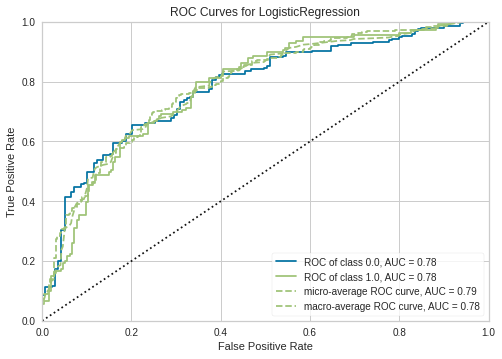

In [31]:
plot_model(model)

In [33]:
tuned_lr = tune_model(model
                      ,fold = 5
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6816,0.7723,0.6667,0.6087,0.6364,0.3542,0.3554
1,0.6716,0.7073,0.7143,0.5882,0.6452,0.3449,0.3505
2,0.7100,0.7834,0.6429,0.6585,0.6506,0.4028,0.4029
3,0.6550,0.7348,0.6024,0.5814,0.5917,0.2932,0.2933
4,0.7300,0.7939,0.7470,0.6526,0.6966,0.4554,0.4587
Mean,0.6896,0.7583,0.6746,0.6179,0.6441,0.3701,0.3722
Std,0.0270,0.0324,0.0512,0.0321,0.0335,0.0550,0.0555


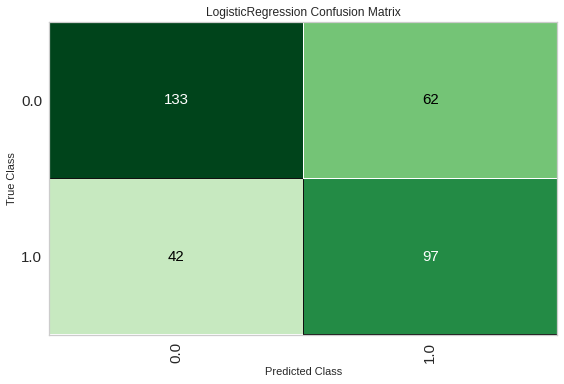

In [44]:
#plotting confusion matrix for predicted labels
plot_model(tuned_lr, plot = 'confusion_matrix')

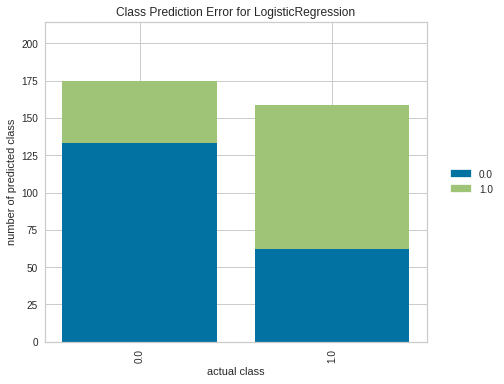

In [46]:
# plotting number of correctly
# classified and misclassifed labels
plot_model(tuned_lr, plot = 'error')

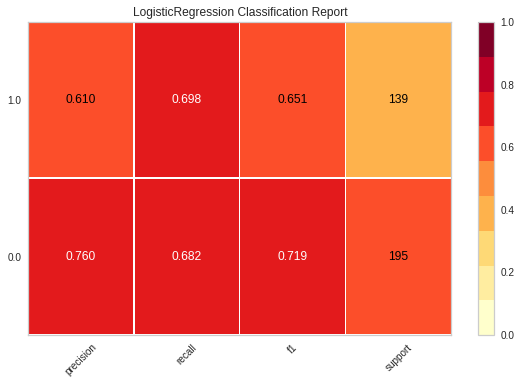

In [47]:
# plotting classification report
plot_model(tuned_lr, plot = 'class_report')

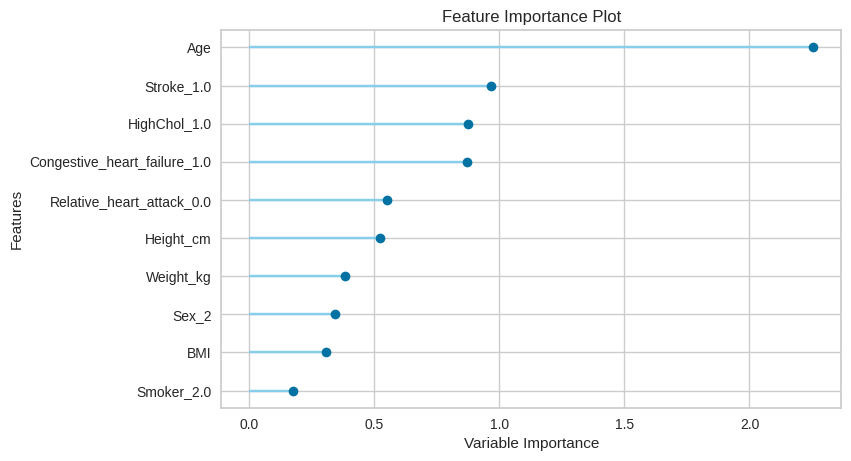

In [34]:
plot_model(estimator = tuned_lr, plot = 'feature')

In [35]:
df_predict = predict_model(tuned_lr, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6991,0.7718,0.6894,0.6264,0.6564,0.3899,0.3913


In [36]:
df_predict


,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Hemoglobin_concentration,Congestive_heart_failure,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker,Label,Score
0,1.0,26.7,78.3,1.0,1.0,122.0,33.4,0.0,1.0,0.0,0.0,1,69.0,175.26,3.0,1.0,0.8482
1,1.0,28.6,89.5,1.0,1.0,156.0,32.5,0.0,0.0,0.0,0.0,1,54.0,180.34,2.0,1.0,0.5930
2,1.0,28.9,88.9,1.0,1.0,140.0,34.3,0.0,0.0,1.0,0.0,1,72.0,177.80,3.0,1.0,0.8043
5,1.0,41.7,105.0,1.0,1.0,160.0,34.2,0.0,0.0,0.0,1.0,1,56.0,162.56,3.0,1.0,0.6104
9,1.0,22.0,65.3,0.0,0.0,140.0,35.3,0.0,0.0,0.0,1.0,2,56.0,154.94,1.0,0.0,0.5587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788,1.0,22.5,57.7,0.0,1.0,106.0,34.9,0.0,0.0,1.0,0.0,1,54.0,185.42,3.0,1.0,0.6834
9790,1.0,24.3,71.7,0.0,1.0,116.0,34.3,0.0,0.0,1.0,0.0,2,80.0,170.18,3.0,1.0,0.8875
9794,1.0,23.7,62.5,0.0,1.0,118.0,31.2,0.0,0.0,1.0,0.0,1,63.0,177.80,3.0,1.0,0.7494
9799,1.0,27.4,74.7,0.0,0.0,114.0,33.7,0.0,0.0,0.0,0.0,2,21.0,157.48,1.0,0.0,0.8463


In [37]:
df_predict["Label"].value_counts()

0.0    723
1.0    613
Name: Label, dtype: int64

In [38]:
final = finalize_model(tuned_lr)

In [39]:
saved = save_model(final, 'model')

Transformation Pipeline and Model Successfully Saved


In [40]:
my_model = load_model('model')

Transformation Pipeline and Model Successfully Loaded


In [41]:

'''
data_teste = pd.DataFrame()
data_teste['HighBP'] = [1]  
data_teste['HighChol'] = [1]
data_teste['BMI'] = [31]
data_teste['Smoker'] = [1] 
data_teste['Stroke'] = [1]
data_teste['HeartDiseaseorAttack'] = [1] 
data_teste['Fruits'] = [0] 
data_teste['Veggies'] = [0]
data_teste['HvyAlcoholConsump'] = [1]
data_teste['GenHlth'] = [5]
data_teste['Sex'] = [1]
data_teste['Age'] = [63]
data_teste['Drink_alcohol'] = [1]
data_teste['Weight_kg'] = [100]
data_teste['Systolic_bp'] = [135]
data_teste['Diastolic_bp'] = [60]
data_teste['Hemoglobin_concentration'] = [32]
data_teste['Congestive_heart_failure'] = [0]
data_teste['Coronary_heart_disease'] = [0]
data_teste['Angina'] = [0]
data_teste['Heart_attack'] = [0]
data_teste['Relative_heart_attack'] = [1]
data_teste['Exercising'] = [0]
data_teste['BP_status'] = [1]
data_teste['Height_cm'] = [180]
'''

data_teste = pd.DataFrame()
data_teste['HighChol'] = [1.0]
data_teste['BMI'] = [28.0]
data_teste['Smoker'] = [1.0] 
data_teste['Stroke'] = [1.0]
data_teste['Sex'] = [1.0]
data_teste['Age'] = [33.0]
data_teste['Drink_alcohol'] = [1.0]
data_teste['Weight_kg'] = [54.0]
data_teste['Systolic_bp'] = [120.0]
data_teste['Hemoglobin_concentration'] = [33.0]
data_teste['Congestive_heart_failure'] = [0.0]
data_teste['Relative_heart_attack'] = [0.0]
data_teste['Exercising'] = [0.0]
data_teste['Height_cm'] = [165.0]



''' data_teste = pd.DataFrame()
data_teste['HighChol'] = [0.0]
data_teste['BMI'] = [22.0]
data_teste['Smoker'] = [0.0] 
data_teste['Stroke'] = [0.0]
data_teste['Sex'] = [1.0]
data_teste['Age'] = [33.0]
data_teste['Drink_alcohol'] = [0.0]
data_teste['Weight_kg'] = [54.0]
data_teste['Systolic_bp'] = [120.0]
data_teste['Hemoglobin_concentration'] = [33.0]
data_teste['Congestive_heart_failure'] = [0.0]
data_teste['Relative_heart_attack'] = [0.0]
data_teste['Exercising'] = [1.0]
data_teste['Height_cm'] = [165.0]
'''


#realiza a predição.
result = predict_model(my_model, data=data_teste)

#recupera os resultados.
classe = result["Label"][0]
prob = result["Score"][0]*100

print(classe)
print(prob)


1.0
59.95
